In [102]:
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import leastsq

In [8]:
# Function to parse CIF and extract lattice parameters and atomic positions
def parse_cif(cif_filename):
    lattice_params = {}
    atom_positions = []
    atom_data_start = False  # Flag to mark when atom positions start
    
    with open(cif_filename, 'r') as file:
        lines = file.readlines()
    
    # Loop through the lines to extract the necessary data
    for i, line in enumerate(lines):
        line = line.strip()
        
        # Lattice parameters
        if '_cell_length_a' in line:
            lattice_params['a'] = float(line.split()[1])
        elif '_cell_length_b' in line:
            lattice_params['b'] = float(line.split()[1])
        elif '_cell_length_c' in line:
            lattice_params['c'] = float(line.split()[1])
        elif '_cell_angle_alpha' in line:
            lattice_params['alpha'] = float(line.split()[1])
        elif '_cell_angle_beta' in line:
            lattice_params['beta'] = float(line.split()[1])
        elif '_cell_angle_gamma' in line:
            lattice_params['gamma'] = float(line.split()[1])
        
        # Find the start of the atom position section (after '_atom_site_label' or equivalent headers)
        if '_atom_site_label' in line:
            atom_data_start = True
            continue  # Skip the header line
    
        # Extract atom positions from the lines following '_atom_site_label'
        if atom_data_start:
            atom_line = line.split()
            
            # Make sure we are dealing with lines that contain valid atomic positions
            if len(atom_line) >= 6:
                try:
                    # Atom positions are in columns 5, 6, and 7
                    atom_positions.append({
                        'label': atom_line[0],
                        'x': float(atom_line[4]),  # Fractional x coordinate
                        'y': float(atom_line[5]),  # Fractional y coordinate
                        'z': float(atom_line[6])   # Fractional z coordinate
                    })
                except ValueError:
                    # If a line can't be parsed to floats, continue to the next line
                    continue

            # Stop reading atom positions if we encounter an empty line or the end of the list
            if 'loop_' in atom_line or len(atom_line) == 0:
                break

    return lattice_params, atom_positions

In [9]:
# Example usage:
cif_filename = 'CdSe_zinc-blende.cif'
lattice_params, atom_positions = parse_cif(cif_filename)

print("Lattice Parameters:", lattice_params)
print("Atom Positions:", atom_positions)

Lattice Parameters: {'a': 6.077, 'b': 6.077, 'c': 6.077, 'alpha': 90.0, 'beta': 90.0, 'gamma': 90.0}
Atom Positions: [{'label': 'Cd1', 'x': 0.0, 'y': 0.0, 'z': 0.0}, {'label': 'Se1', 'x': 0.25, 'y': 0.25, 'z': 0.25}]


In [11]:
# Read experimental PDF data (CdSe.gr)
def read_experimental_pdf(filename):
    # Load the data
    data = np.loadtxt(filename, delimiter=' ')
    r_exp = data[:, 0]  # First column: distances (r)
    g_exp = data[:, 1]  # Second column: PDF values (g)
    return r_exp, g_exp

# Plot the experimental PDF
def plot_experimental_pdf(r_exp, g_exp):
    plt.figure(figsize=(8, 5))
    plt.plot(r_exp, g_exp, label="Experimental PDF", color='blue')
    plt.xlabel('r (Å)')
    plt.ylabel('g(r)')
    plt.title('Experimental PDF for CdSe')
    plt.legend()
    plt.show()

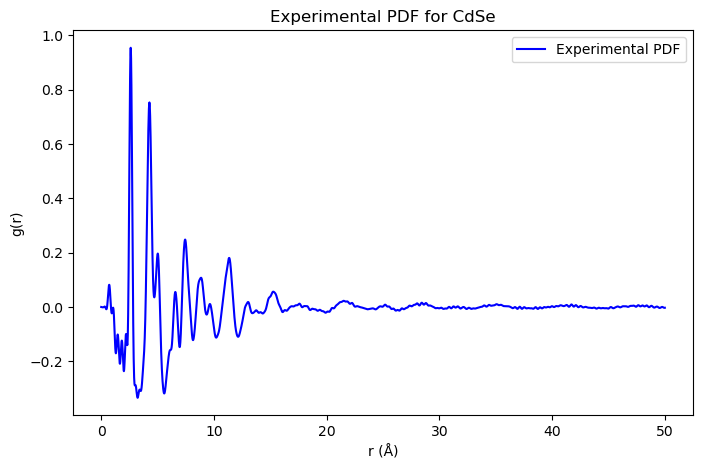

In [12]:
# Example usage
r_exp, g_exp = read_experimental_pdf('CdSe.gr')
plot_experimental_pdf(r_exp, g_exp)

In [19]:
# Function to convert fractional to Cartesian coordinates
def frac_to_cartesian(fractional_coords, lattice_params):
    a, b, c = lattice_params['a'], lattice_params['b'], lattice_params['c']
    alpha, beta, gamma = np.radians(lattice_params['alpha']), np.radians(lattice_params['beta']), np.radians(lattice_params['gamma'])

    # Construct lattice vectors
    lattice_matrix = np.array([[a, 0, 0],
                               [b * np.cos(gamma), b * np.sin(gamma), 0],
                               [c * np.cos(beta), c * (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma), 
                                c * np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 
                                            2 * np.cos(alpha) * np.cos(beta) * np.cos(gamma))]])
    
    # Convert fractional to Cartesian coordinates
    cartesian_coords = np.dot(fractional_coords, lattice_matrix)
    return cartesian_coords

# Function to generate the theoretical PDF
def generate_theoretical_pdf(atom_positions, lattice_params, r_max=20, dr=0.1, supercell_size=3, sigma=0.1):
    # Expand the lattice into a supercell
    expanded_atoms = []
    for nx in range(supercell_size):
        for ny in range(supercell_size):
            for nz in range(supercell_size):
                for atom in atom_positions:
                    expanded_atoms.append({
                        'label': atom['label'],
                        'x': atom['x'] + nx,
                        'y': atom['y'] + ny,
                        'z': atom['z'] + nz
                    })

    # Convert fractional coordinates to Cartesian coordinates
    fractional_coords = np.array([[atom['x'], atom['y'], atom['z']] for atom in expanded_atoms])
    cartesian_coords = frac_to_cartesian(fractional_coords, lattice_params)

    # Generate PDF
    r_vals = np.arange(0, r_max, dr)
    pdf_vals = np.zeros_like(r_vals)

    for i, atom1 in enumerate(cartesian_coords):
        for j, atom2 in enumerate(cartesian_coords):
            if i < j:  # Only compute each pair once
                distance = np.linalg.norm(atom1 - atom2)
                # Add Gaussian contribution for this distance
                pdf_vals += np.exp(-(r_vals - distance)**2 / (2 * sigma**2))

    # Normalize the PDF by subtracting the average value
    pdf_vals -= np.mean(pdf_vals)

    return r_vals, pdf_vals

# Plot the theoretical PDF
def plot_theoretical_pdf(r_vals, pdf_vals):
    plt.figure(figsize=(8, 5))
    plt.plot(r_vals, pdf_vals, label="Theoretical PDF", color='red')
    plt.xlabel('r (Å)')
    plt.ylabel('g(r)')
    plt.title('Theoretical PDF for CdSe')
    plt.legend()
    plt.show()

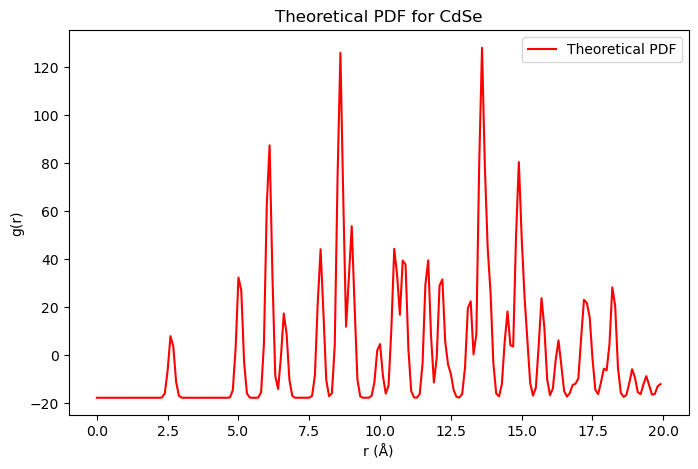

In [20]:
# Example usage
r_theory, g_theory = generate_theoretical_pdf(atom_positions, lattice_params, r_max=20, dr=0.1, supercell_size=3, sigma=0.1)
plot_theoretical_pdf(r_theory, g_theory)

(0.0, 20.0)

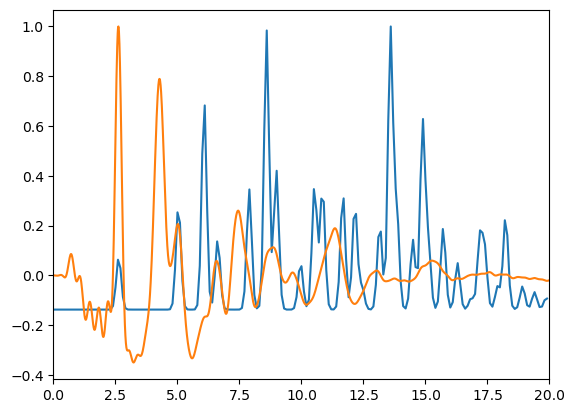

In [22]:
plt.plot(r_theory, g_theory/np.max(g_theory))
plt.plot(r_exp, g_exp/np.max(g_exp))
plt.xlim(0,20)

In [88]:
# Function to subtract baseline and convert RDF-like to PDF-like
def subtract_baseline_and_center_pdf(r_vals, pdf_vals, lattice_params, atom_positions):
    # Estimate the average atomic density
    volume = lattice_params['a'] * lattice_params['b'] * lattice_params['c']
    num_atoms = len(atom_positions) * 3**3  # Adjust for the supercell
    rho_0 = num_atoms / volume  # Average atomic density
    
    # Baseline function: assumes linear growth with r due to RDF-like behavior
    baseline = 4 * np.pi * rho_0 * r_vals
    
    # Subtract baseline from PDF
    pdf_vals_corrected = pdf_vals - baseline

    return pdf_vals_corrected

# Integrating the baseline correction into the generation of the PDF
def generate_theoretical_pdf_corrected(atom_positions, lattice_params, r_max=20, dr=0.1, supercell_size=3, sigma=0.1, damping_factor=10):
    # Expand the lattice and calculate pair distances (same as before)
    expanded_atoms = []
    for nx in range(supercell_size):
        for ny in range(supercell_size):
            for nz in range(supercell_size):
                for atom in atom_positions:
                    expanded_atoms.append({
                        'label': atom['label'],
                        'x': atom['x'] + nx,
                        'y': atom['y'] + ny,
                        'z': atom['z'] + nz
                    })

    # Convert fractional coordinates to Cartesian
    fractional_coords = np.array([[atom['x'], atom['y'], atom['z']] for atom in expanded_atoms])
    cartesian_coords = frac_to_cartesian(fractional_coords, lattice_params)

    # Generate PDF
    r_vals = np.arange(0, r_max, dr)
    pdf_vals = np.zeros_like(r_vals)

    for i, atom1 in enumerate(cartesian_coords):
        for j, atom2 in enumerate(cartesian_coords):
            if i < j:  # Only compute each pair once
                distance = np.linalg.norm(atom1 - atom2)
                # Add Gaussian contribution for this distance
                pdf_vals += np.exp(-(r_vals - distance)**2 / (2 * sigma**2))

    # Subtract baseline
    pdf_vals_corrected = subtract_baseline_and_center_pdf(r_vals, pdf_vals, lattice_params, atom_positions)

    # Apply a damping factor
    damping = np.exp(-r_vals / damping_factor)
    pdf_vals_corrected *= damping

    return r_vals, pdf_vals_corrected

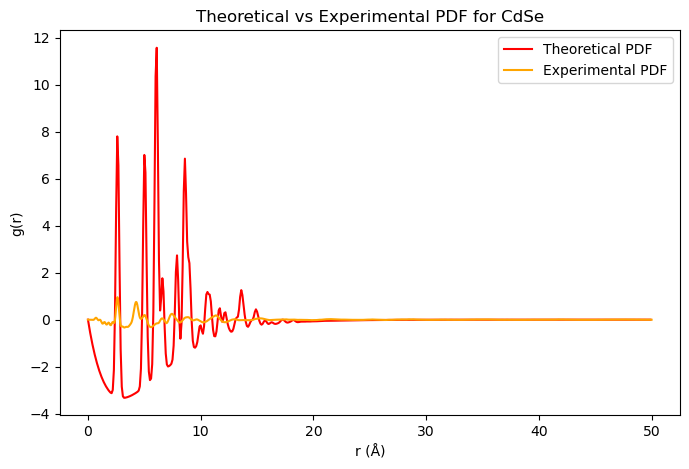

In [99]:
# Example usage
r_theory, g_theory_corrected = generate_theoretical_pdf_corrected(atom_positions, lattice_params, r_max=50, dr=0.1, supercell_size=3, sigma=0.15, damping_factor=3)

# Plot with experimental data
plot_theoretical_pdf_with_experiment(r_theory, g_theory_corrected, r_exp, g_exp)

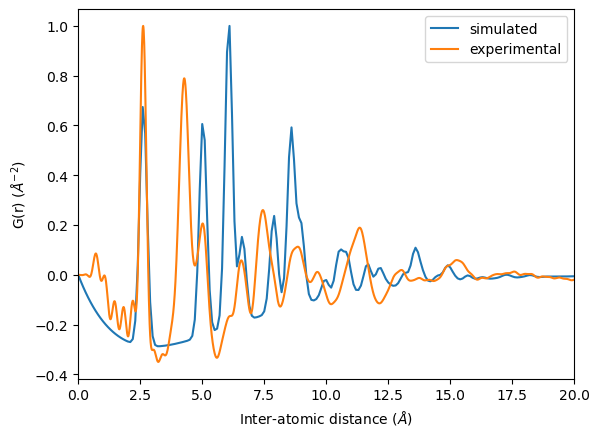

In [100]:
plt.plot(r_theory, g_theory_corrected/np.max(g_theory_corrected), label='simulated')
plt.plot(r_exp, g_exp/np.max(g_exp), label='experimental')
plt.xlim(0,20)
plt.xlabel(r'Inter-atomic distance ($\AA$)')
plt.ylabel(r'G(r) ($\AA^{-2}$)')
plt.legend(loc='best')

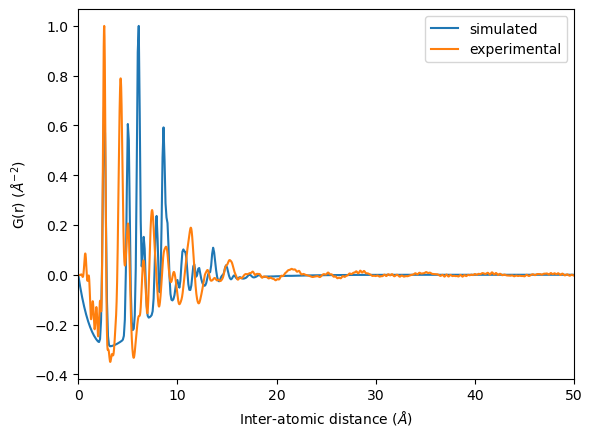

In [101]:
plt.plot(r_theory, g_theory_corrected/np.max(g_theory_corrected), label='simulated')
plt.plot(r_exp, g_exp/np.max(g_exp), label='experimental')
plt.xlim(0,50)
plt.xlabel(r'Inter-atomic distance ($\AA$)')
plt.ylabel(r'G(r) ($\AA^{-2}$)')
plt.legend(loc='best')

In [112]:
# Function to compute Rw value with normalization
def compute_Rw_normalized(g_exp, g_theory):
    # Normalize both experimental and theoretical PDFs to have maximum absolute value of 1
    g_exp_norm = g_exp / np.max(np.abs(g_exp))
    g_theory_norm = g_theory / np.max(np.abs(g_theory))
    
    # Compute Rw (residual)
    return np.sum((g_exp_norm - g_theory_norm) ** 2) / np.sum(g_exp_norm ** 2)

def residual(params, r_exp, g_exp, atom_positions):
    # Extract parameters
    lattice_params = {'a': params[0], 'b': params[1], 'c': params[2], 'alpha': 90, 'beta': 90, 'gamma': 90}
    sigma = params[3]
    damping_factor = params[4]
    
    # Generate the theoretical PDF with current parameters
    r_theory, g_theory = generate_theoretical_pdf_corrected(atom_positions, lattice_params, r_max=50, dr=0.1, supercell_size=3, sigma=sigma, damping_factor=damping_factor)
    
    # Interpolate theoretical PDF to match experimental r values
    g_theory_interp = np.interp(r_exp, r_theory, g_theory)
    
    # Normalize both experimental and theoretical PDFs to have a maximum value of 1
    g_exp_norm = g_exp / np.max(g_exp)
    g_theory_norm = g_theory_interp / np.max(g_theory_interp)
    
    # Return the difference (residual) between the normalized experimental and theoretical PDFs
    return g_exp_norm - g_theory_norm

# Example initial parameters (lattice a, b, c, sigma, damping_factor)
initial_params = [lattice_params['a'], lattice_params['b'], lattice_params['c'], 0.15, 3]

# Compute Rw before running the optimization
Rw = residual(initial_params, r_exp, g_exp, atom_positions)
print(f"Initial Rw: {Rw}")

Initial Rw: [-3.47658979e-67  2.46827375e-03  4.93213949e-03 ... -3.24623947e-03
 -3.16604986e-03 -3.05560834e-03]


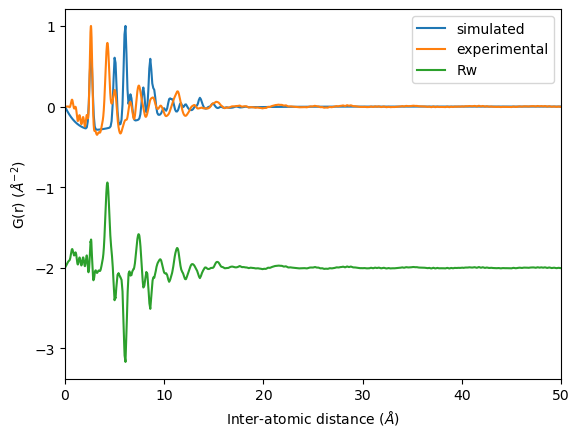

In [118]:
plt.plot(r_theory, g_theory_corrected/np.max(g_theory_corrected), label='simulated')
plt.plot(r_exp, g_exp/np.max(g_exp), label='experimental')
plt.plot(r_exp, Rw-2, label='Rw')
plt.xlim(0,50)
plt.xlabel(r'Inter-atomic distance ($\AA$)')
plt.ylabel(r'G(r) ($\AA^{-2}$)')
plt.legend(loc='best')

In [110]:
# Function to perform least-squares optimization
def optimize_pdf(r_exp, g_exp, atom_positions, initial_params):
    # Run least-squares optimization
    result = leastsq(residual, initial_params, args=(r_exp, g_exp, atom_positions), full_output=1)
    
    # Extract optimized parameters
    optimized_params = result[0]
    
    # Extract the optimized lattice parameters, sigma, and damping factor
    optimized_lattice_params = {
        'a': optimized_params[0],
        'b': optimized_params[1],
        'c': optimized_params[2],
        'alpha': 90,  # Assume 90 degrees for cubic structure
        'beta': 90,
        'gamma': 90
    }
    optimized_sigma = optimized_params[3]
    optimized_damping_factor = optimized_params[4]
    
    return optimized_lattice_params, optimized_sigma, optimized_damping_factor

In [129]:
# Example initial parameters (lattice a, b, c, sigma, damping_factor)
initial_params = [lattice_params['a'], lattice_params['b'], lattice_params['c'], 0.15, 3]

# Run the optimization
optimized_lattice_params, optimized_sigma, optimized_damping_factor = optimize_pdf(r_exp, g_exp, atom_positions, initial_params)

# Output the optimized results
print(f"Initial parameters: {initial_params}")
print(f"Optimized lattice parameters: {optimized_lattice_params}")
print(f"Optimized sigma: {optimized_sigma}")
print(f"Optimized damping factor: {optimized_damping_factor}")

Initial parameters: [6.077, 6.077, 6.077, 0.15, 3]
Optimized lattice parameters: {'a': 6.1009878312371795, 'b': 6.10099135151447, 'c': 6.1009938877064105, 'alpha': 90, 'beta': 90, 'gamma': 90}
Optimized sigma: 0.062172169130105585
Optimized damping factor: 3.4554383989094775


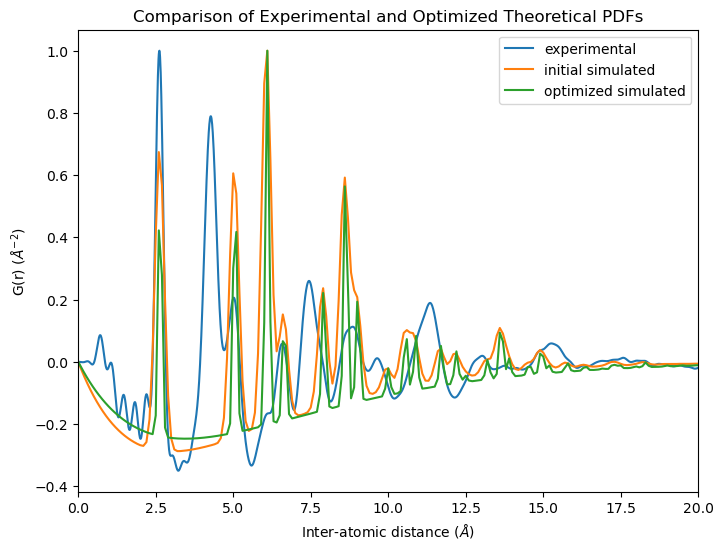

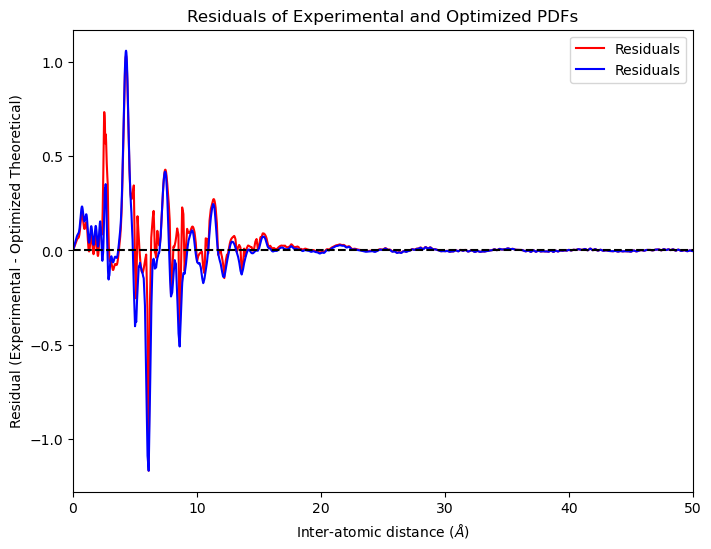

In [132]:
# Use the optimized lattice parameters to generate the optimized theoretical PDF
r_theory_opt, g_theory_opt = generate_theoretical_pdf_corrected(atom_positions, optimized_lattice_params, r_max=50, dr=0.1, supercell_size=3, sigma=optimized_sigma, damping_factor=optimized_damping_factor)

# Interpolate the optimized PDF to match the experimental r values
g_theory_interp_opt = np.interp(r_exp, r_theory_opt, g_theory_opt)

# Normalize both the experimental and optimized theoretical PDFs
g_exp_norm = g_exp / np.max(g_exp)
g_theory_norm_opt = g_theory_interp_opt / np.max(g_theory_interp_opt)

# Plot the experimental and optimized theoretical PDFs
plt.figure(figsize=(8, 6))
plt.plot(r_exp, g_exp_norm, label='experimental')
plt.plot(r_theory, g_theory_corrected/np.max(g_theory_corrected), label='initial simulated')
plt.plot(r_exp, g_theory_norm_opt, label='optimized simulated')
plt.xlim(0, 20)
plt.xlabel(r'Inter-atomic distance ($\AA$)')
plt.ylabel(r'G(r) ($\AA^{-2}$)')
plt.legend(loc='best')
plt.title('Comparison of Experimental and Optimized Theoretical PDFs')
plt.show()

# Calculate the residual (difference between experimental and optimized PDF)
residuals = g_exp_norm - g_theory_norm_opt

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.plot(r_exp, residuals, label='Residuals', color='red')
plt.plot(r_exp, Rw, label='Residuals', color='blue')
plt.axhline(0, color='black', linestyle='--')  # Add a line at zero for reference
plt.xlim(0, 50)
plt.xlabel(r'Inter-atomic distance ($\AA$)')
plt.ylabel('Residual (Experimental - Optimized Theoretical)')
plt.title('Residuals of Experimental and Optimized PDFs')
plt.legend(loc='best')
plt.show()

Need to add atom_positions into the optimization to make it work correctly